# <a id='toc1_'></a>[Model Benchmarking](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Model Benchmarking](#toc1_)    
  - [Imports](#toc1_1_)    
  - [GLOBALS](#toc1_2_)    
  - [Model 1: Baseline (Only Numeric Features)](#toc1_3_)    
      - [LINE ASSUMPTIONS](#toc1_3_1_1_)    
  - [Model 2: Dummify all categorical variables + Numeric Vals:](#toc1_4_)    
      - [All Dummies + Numerics Assumption Testing:](#toc1_4_1_1_)    
  - [Model 3: All numeric values and categorical dummies](#toc1_5_)    
      - [Line Assumptions:](#toc1_5_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

___

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('../datasets/no_missings_train.csv')

## <a id='toc1_2_'></a>[GLOBALS](#toc0_)

In [3]:
NUMERIC = [
    'lot_area',
    'low_qual_fin_sf', 
    'gr_liv_area',
    'wood_deck_sf',
    'open_porch_sf',
    'pool_area',
    'total_bsmt_sf',
    'bsmtfin_sf_1',
    'bsmt_unf_sf',
    'bsmtfin_sf_2',
    'lot_frontage',
    'mas_vnr_area',
    'garage_area',
    'overall_qual',
    'overall_cond',
    '1st_flr_sf',
    '2nd_flr_sf',
    'bsmt_full_bath',
    'bsmt_half_bath',
    'full_bath',
    'half_bath',
    'bedroom_abvgr',
    'kitchen_abvgr',
]
OHE_COLS = list(df.drop(columns=[
    *NUMERIC,
    'id',
    'pid',
    'saleprice'
    ]).columns)

## <a id='toc1_3_'></a>[Model 1: Baseline (Only Numeric Features)](#toc0_)

In [4]:
# Train test split:
X = df.drop(columns=[*OHE_COLS,'saleprice'])
y = df.saleprice

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=.3,random_state=1234)

# Fit and r2 score
lr = LinearRegression()
lr.fit(Xtrain,ytrain)
print(lr.score(Xtrain,ytrain))
lr.score(Xtest,ytest)

0.8576088332918843


0.8632749166351172

In [5]:
# make predictions and score the model
yhat = lr.predict(Xtest)
np.sqrt(metrics.mean_squared_error(ytest,yhat))

29093.48318624422

#### <a id='toc1_3_1_1_'></a>[LINE ASSUMPTIONS](#toc0_)

Now we have a decent baseline score to improve from! Let's make sure we aren't violating any assumptions.

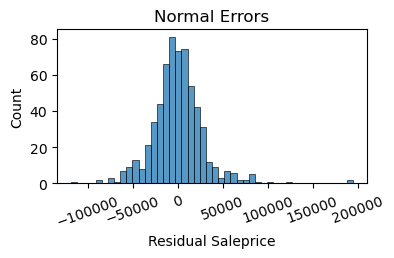

In [6]:
resids = ytest - yhat
plt.figure(figsize=(4,2))
plt.title('Normal Errors')
plt.xticks(rotation=20)
plt.xlabel('Residual Saleprice')
sns.histplot(resids);

More on assumptions later.

---

## <a id='toc1_4_'></a>[Model 2: Dummify all categorical variables + Numeric Vals:](#toc0_)

In [7]:
# Create data
X = pd.get_dummies(
        df,
        columns=OHE_COLS,
        drop_first=True
    ).drop(columns='saleprice')
y = df.saleprice

In [8]:
# Train test split:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=.3,random_state=1234, shuffle=True)

lr = LinearRegression()
lr.fit(Xtrain,ytrain)
lr.score(Xtest,ytest)

0.8386944073744662

In [9]:
yhat_train = lr.predict(Xtrain)
np.sqrt(metrics.mean_squared_error(ytrain,yhat_train))

12995.368744158643

In [10]:
yhat = lr.predict(Xtest)
np.sqrt(metrics.mean_squared_error(ytest,yhat))

31600.673147194408

#### <a id='toc1_4_1_1_'></a>[All Dummies + Numerics Assumption Testing:](#toc0_)

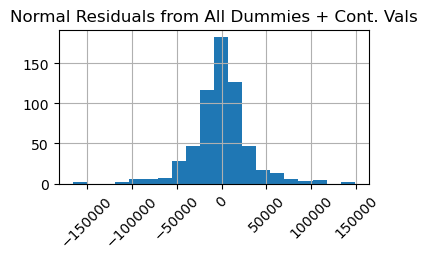

In [11]:
resids = ytest-yhat
plt.figure(figsize=(4,2))
plt.title('Normal Residuals from All Dummies + Cont. Vals')
plt.xticks(rotation=45)
resids.hist(bins=20);

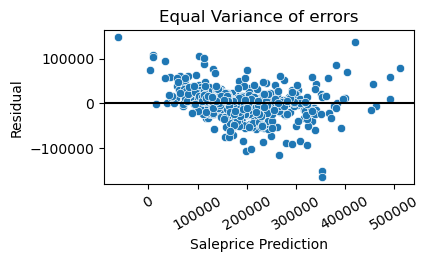

In [12]:
plt.figure(figsize=(4,2))
plt.title('Equal Variance of errors')
plt.axhline(0,c='black')
plt.xticks(rotation=30)
sns.scatterplot(x=yhat, y=resids)
plt.ylabel('Residual')
plt.xlabel('Saleprice Prediction');

---

## <a id='toc1_5_'></a>[Model 3: All numeric values and categorical dummies](#toc0_)

In [13]:
POLY_COLS = [
    "lot_area",
    "overall_qual",
]

In [14]:
X = pd.get_dummies(
        df,
        columns=OHE_COLS,
        drop_first=True
    ).drop(columns='saleprice')

y = df.saleprice

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=.3,random_state=1234, shuffle=True)

In [16]:
pf = PolynomialFeatures(degree=3,interaction_only=False, include_bias=False)

In [17]:
Xtrain_pf = pd.DataFrame(pf.fit_transform(Xtrain[POLY_COLS]))
Xtrain_pf.columns = map(str,Xtrain_pf.columns)
Xtrain = Xtrain.join(Xtrain_pf,how='left')
Xtrain = Xtrain.fillna(0)


In [18]:

Xtest_pf = pd.DataFrame(pf.transform(Xtest[POLY_COLS]))
Xtest_pf.columns = map(str,Xtest_pf.columns)
Xtest = Xtest.join(Xtest_pf,how='left')
Xtest = Xtest.fillna(0)


In [19]:
lr.fit(Xtrain,ytrain)
print('Training r2: ', lr.score(Xtrain,ytrain))
print('Testing  r2: ', lr.score(Xtest,ytest))

Training r2:  0.9303278265925177
Testing  r2:  0.8724966009637987


In [20]:
# Train RMSE
yhat_train = lr.predict(Xtrain)
np.sqrt(metrics.mean_squared_error(ytrain,yhat_train))

20991.712246217096

In [21]:
# Test RMSE
yhat = lr.predict(Xtest)
np.sqrt(metrics.mean_squared_error(ytest,yhat))

28095.224233818106

In [22]:
# create some stuff:


#### <a id='toc1_5_1_1_'></a>[Line Assumptions:](#toc0_)

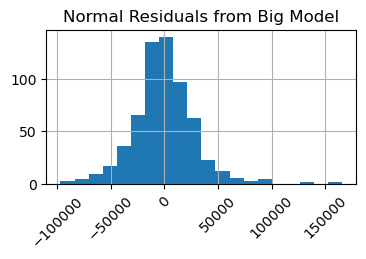

In [23]:
resids = ytest-yhat
plt.figure(figsize=(4,2))
plt.title('Normal Residuals from Big Model')
plt.xticks(rotation=45)
resids.hist(bins=20);

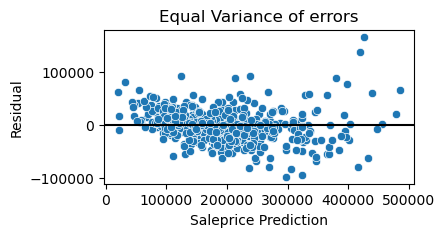

In [24]:
plt.figure(figsize=(4,2))
plt.title('Equal Variance of errors')
plt.axhline(0,c='black')
sns.scatterplot(x=yhat, y=resids)
plt.ylabel('Residual')
plt.xlabel('Saleprice Prediction');